# Inspecting TESS light curves for a project
---



In [1]:
# Provide the name of the project and the tess cycle it was observed in: 1 or 2; 3 is not yet set up (probably)
# This project must be set up with TESS_Prep.ipynb, but it doesn't have to be a Cantat-Gaudin cluster catalog. 


project_name = 'IC_2602'



**Import Python modules**
Python comes with only some basic functions pre-loaded. All other computer programs are included in "modules," which must be imported.

In [2]:
# Plotting program
import matplotlib.pyplot as plt

# Plots are shown in the notebook
%matplotlib inline

# Searches for files
from glob import glob

# Good for reading/writing data tables
import pandas as pd
from astropy.table import Table

# Better math, numbers, and array functions
import numpy as np

# How long does something take?
import time

# I forget what this does.
import warnings
warnings.filterwarnings('ignore')

**Set up directories**

In [3]:
# The main directory in Google Drive:
dir_drive = "/content/gdrive/My Drive/Research/"
dir_main = dir_drive # i have a bad habit of using dir_main and dir_drive interchangeably so i'll define both here.

# The various clusters we will analyze are organized in the "Projects" folder according to the name of the cluster.
# The "project_name" is set at the top of this notebook
dir_project = dir_drive + "tess_check/" + project_name + "/"

**Authorize access to our Drive**

In [4]:
# We need to give this notebook access to the data stored in our Google Drive.
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

# Google Colab has access to many of the Python modules we will need, and are available for import
# Others are not pre-installed, but are accessible online and can be downloaded and installed via pip (e.g., astroquery)
# However, our code is stored in our Drive. We have to tell the computer where it is located so that it will be available for import:
import sys
# First, we need to tell the system where it can locate the Python modules. This is done by adding the directories to the "path.""
# After that, we can import our modules just like we did previously for those already installed on the Google servers.

#### I have my own Python codes saved in folders located in /content/gdrive/My Drive/PythonCode/. I've modified this for Mark.
sys.path.append(dir_main)
# If/when you move these programs, you will need to edit myDir.py and then update its path name in the imports in tess_tools.py and tesscheck.py
from tess_check import myDir as myDir

# Test to make sure myDir is working properly
dir_project_function = myDir.project_dir(project_name)
if dir_project_function != dir_project:
  print('There is a problem with the "myDir" program. It is loading the incorrect path for the project')

Mounted at /content/gdrive/


In [5]:
# from tess_check.sheet import load_sheet, get_prot_table
# from tess_check.status import read_status
# from tess_check.lightcurves import find_sap, find_cpm
# from tess_check.lightcurves import load_cpm, load_cpm_fromfile, load_sap
# from tess_check.ffis import find_ffi, load_ffi_fromfile, ffi_test
# from tess_check.sheet import get_prot_table


In [6]:
from tess_check import status
from tess_check import tesscheck
from tess_check import users

**Check the status of this project**

Each project includes a status file (status.txt), which includes some basic information on what has been done already. 

In [7]:
status_exist = glob(dir_project+'Status.txt')
if np.size(status_exist) == 0:
  status.make_status(project_name,reset=True)  
  exist = 0
  while exist == 0:
    status_exist = glob(dir_project+'Status.txt')
    if len(status_exist)>0:
      print("status.txt has been created")
      exist = 1
      project_status = status.read_status(project_name)
else:
  project_status = status.read_status(project_name)
project_status

# the first time this is run takes awhile becuase Drive is slow to recognize new files. 

{'Auto': 'Yes',
 'Project': 'IC_2602',
 'Steps': 'Status_Initialized',
 'Users': 'Jason Team_Member Stephanie'}

**Auto-inspect all TESS data** **SKIP**

Before a user inspects the TESS data, they must be analyzed automatically and indpendently by the computer. 

In [8]:
# Check if it has been run...

# check if Status.txt exists
# read Status.txt
project_status = status.read_status(project_name)
if project_status['Auto'] == 'No':
  # if auto hasnt been run yet, then do it.
#  tesscheck_auto(project_name)
  tesscheck.tesscheck_auto(project_name, tess_cycle=1, redo=False)
  # update Status.txt
  status.make_status(project_name,change_auto='Yes')
else:
  print('Auto-inspect completed.')


Auto-inspect completed.


20


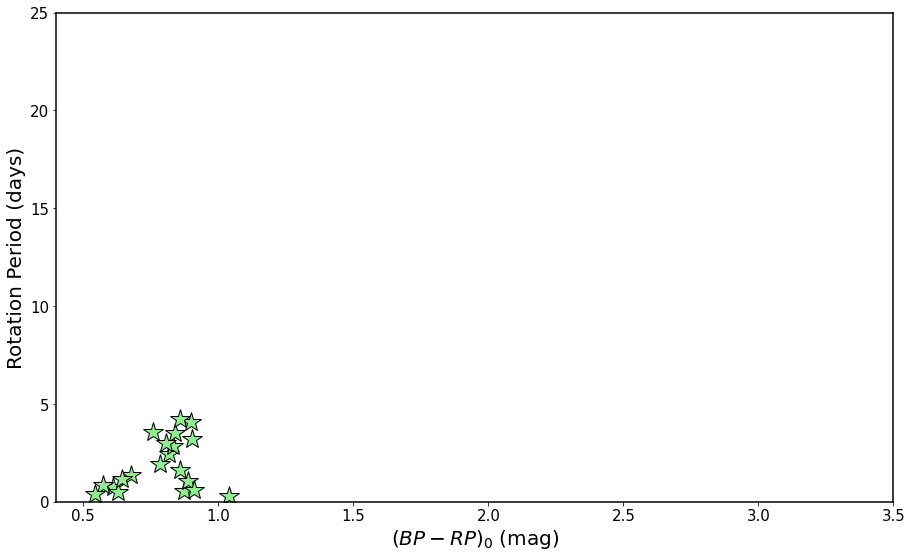

In [9]:
tesscheck.prot_auto_show(project_name, clusters=False, pcut=0.1, av=0)

**Identify the user**
The user must log in. If you are a new user (your name is not listed), select "other," then enter your name when prompted. This will add your profile to the results spreadsheet (ComaBer), and update the users listed in the status.txt file.

In [10]:
# It takes ~4 seconds to verify an existing user, and ~10 seconds to add a new user.
user = users.tess_user(project_name)

Which user? Press...
   1 for Jason
   2 for Team_Member
   3 for Stephanie
   4 for Other
3
Stephanie is logged in.
Making sheet for new user...


**Load our project table (the Googele Sheet "ComaBer")**

This also determines how many stars you still have to analyze.

In [11]:
target_table = tesscheck.get_prot_table('Auto',project_name)
target_data_val = target_table.get_all_values()
target_data = pd.DataFrame.from_records(target_data_val[1:],columns=target_data_val[0])
dr2_list = target_data['DR2Name'].to_numpy()
gbr = target_data['BP_RP'].to_numpy()

prot_table = tesscheck.get_prot_table(user,project_name)
prot_data_val = prot_table.get_all_values()
prot_data = pd.DataFrame.from_records(prot_data_val[1:],columns=prot_data_val[0])

star_list = tesscheck.stars_todo(prot_data)
#star_list = stars_todo_split(prot_data,user)
number_stars = len(star_list)
print(str(number_stars)+' stars to analyze')


21 stars to analyze


**Set up interface (widgets)**

In [12]:
# set up the widgets
axis_fontsize = 16
import matplotlib.pylab as pylab
params = {'axes.labelsize': 16,'axes.titlesize': 16,'xtick.labelsize': 14,'ytick.labelsize': 14}
pylab.rcParams.update(params)

import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
from IPython.core.display import clear_output

'''
sector_widget = widgets.ToggleButtons(
#        options=['All','15', '16'],
        options=['All'],
        description='Sectors:',
        disabled=False,
        button_style=''
        )
'''

lc_widget = widgets.ToggleButtons(
        options=['CPM','SAP'],
        description='Light Curve:',
        disabled=False,
        button_style=''
        )

button_widget = widgets.ToggleButtons(
        options=['Under Review','Publish','Good','Follow up','Flat', 'Garbage'],
        description='Save/Reject:',
        disabled=False,
        button_style=''
        )

sector_widget = widgets.SelectMultiple(
    options=['ready','to','rumble'], 
    value=['ready','to','rumble'], 
    rows=3,
    description='Sectors',
    disabled=False
)

save_widget = widgets.ToggleButtons(
        options=['Continue'],
        description='Save',
        disabled=False,
        button_style=''
        )

yra_widget = widgets.Text(
    value='0.0',
    placeholder='0.0',
    description='Y-range:',
    disabled=False
)

xra_widget = widgets.Text(
    value='0',
    placeholder='0',
    description='X-range: xmin, xmax',
    disabled=False
)

pmin_widget = widgets.Text(
    value='0.09',
    placeholder='0.09',
    description='Min Period:',
    disabled=False
)

pmax_widget = widgets.Text(
    value='30.0',
    placeholder='30.0',
    description='Max Period:',
    disabled=False
)

notes_widget = widgets.Text(
    value='',
    placeholder='',
    description='Add note:',
    disabled=False
)

sap_widget = widgets.Checkbox(False, description='Fit line to SAP?')
xlog_widget = widgets.Checkbox(False, description='X-log?')
double_widget = widgets.Checkbox(False, description='Double the period?')
multi_widget = widgets.Checkbox(False, description='Multi-periodic?')
flare_widget = widgets.Checkbox(False, description='Are there flares?')

print('widgets loaded')

widgets loaded


In [13]:
def meancolor(color):
  spts = ['F3V', 'F4V', 'F5V', 'F6V', 'F7V', 'F8V', 'F9V', 'F9.5V', 'G0V',
        'G1V', 'G2V', 'G3V', 'G4V', 'G5V', 'G6V', 'G7V', 'G8V', 'G9V',
        'K0V', 'K1V', 'K2V', 'K3V', 'K4V', 'K5V', 'K6V', 'K7V', 'K8V',
        'K9V', 'M0V', 'M0.5V', 'M1V', 'M1.5V', 'M2V', 'M2.5V', 'M3V',
        'M3.5V', 'M4V', 'M4.5V', 'M5V', 'M5.5V', 'M6V', 'M6.5V', 'M7V',
        'M7.5V', 'M8V', 'M8.5V', 'M9V', 'M9.5V']
  color_means = np.array([0.518, 0.546, 0.587, 0.64 , 0.67 , 0.694, 0.719, 0.767, 0.784,
        0.803, 0.823, 0.832, 0.841, 0.85 , 0.869, 0.88 , 0.9  , 0.95 ,
        0.983, 1.01 , 1.1  , 1.21 , 1.34 , 1.43 , 1.53 , 1.7  , 1.73 ,
        1.79 , 1.84 , 1.97 , 2.09 , 2.13 , 2.23 , 2.39 , 2.5  , 2.78 ,
        2.94 , 3.16 , 3.35 , 3.71 , 4.16 , 4.5  , 4.65 , 4.72 , 4.86 ,
        5.1  , 4.78 , 4.86 ])
  diferences = np.abs(color_means - color)
  spt = spts[np.argmin(diferences)]
  return(spt)

In [14]:
#Do you want to look at specific objects?
specific = input('y to look at specific objects, n to continue your spreadsheet')
if specific == 'y':
  print('Please provide Gaia DR2 names, comma seperated with no spaces!')
  star_list = input('Which object(s)?=')
  star_list = star_list.split(',')
  number_stars = len(star_list)
  print(str(number_stars)+' stars to analyze')
else:
  target_table = tesscheck.get_prot_table('Auto',project_name)
  target_data_val = target_table.get_all_values()
  target_data = pd.DataFrame.from_records(target_data_val[1:],columns=target_data_val[0])
  dr2_list = target_data['DR2Name'].to_numpy()
  gbr = target_data['BP_RP'].to_numpy()

  prot_table = tesscheck.get_prot_table(user,project_name)
  prot_data_val = prot_table.get_all_values()
  prot_data = pd.DataFrame.from_records(prot_data_val[1:],columns=prot_data_val[0])

  star_list = tesscheck.stars_todo(prot_data)
  #star_list = stars_todo_split(prot_data,user)
  number_stars = len(star_list)
  print(str(number_stars)+' stars to analyze')
do_now = {'i':0,'status':'first', 'step':'a','start_time':0.0}
global tstar #, times, flux
tstar = tesscheck.initiate_star(0,project_name,user=user,blank=True)

y to look at specific objects, n to continue your spreadsheetn
21 stars to analyze


In [15]:

#@widgets.interact_manual(sector_select=sector_widget, lc_select=lc_widget, sap_line = sap_widget, yra=yra_widget, pmin=pmin_widget, pmax=pmax_widget, xlog=xlog_widget, multi=multi_widget, double=double_widget, notes=notes_widget, button=button_widget)
#def plot(sector_select=sector_widget, lc_select=lc_widget, sap_line = sap_widget, yra=yra_widget, pmin=pmin_widget, pmax=pmax_widget, xlog=xlog_widget,multi=multi_widget, double=double_widget, notes=notes_widget, button=button_widget):

@widgets.interact_manual(lc_select=lc_widget, sector_selection = sector_widget, sap_line = sap_widget, xra=xra_widget, yra=yra_widget, pmin=pmin_widget, pmax=pmax_widget, xlog=xlog_widget, multi=multi_widget, flares=flare_widget, double=double_widget,  notes=notes_widget, button=button_widget)
def plot(lc_select=lc_widget, sector_selection = sector_widget, sap_line = sap_widget, xra=xra_widget, yra=yra_widget, pmin=pmin_widget, pmax=pmax_widget, xlog=xlog_widget,multi=multi_widget, flares=flare_widget, double=double_widget, notes=notes_widget, button=button_widget):
# how many observations?
    n_obs = len(star_list)
    print(n_obs)
    print('On star #'+str(do_now['i'])+' of '+str(n_obs))
# Some setup
    global tstar #, times, flux
# Load the observation
    if (do_now['i']<n_obs):
        lead = 'Next star: '
        if do_now['i'] ==0:
            lead = 'First star: '
        print(lead+star_list[do_now['i']],'  Status= ',do_now['status'])
        if len(tstar['Source']) == 0:
            do_now['start_time'] = time.time()
            star = tesscheck.make_star(target_data, star_list[do_now['i']])
            tstar = tesscheck.initiate_star(star,project_name,user=user)
    print('Gmag is '+str(tstar['Gmag'])+' and SpT estimate is '+meancolor(float(tstar['gbr'])))
    tstar['which_sectors'] = tstar['sector_list']


# add in save now?
    save_now = True
    if do_now['status'] == 'first':
#        time_1 = time.time()
        tstar = tesscheck.display_tess_lite_v2(tstar, save = False, noplot = False)
           #mark trying to make sector selector widget do just what we want
        sector_widget.options = tstar['sector_list']
        sector_widget.value = tstar['sector_list'] 
        


#        print('Calculation 1: '+str(time.time()-time_1))
    print('Sectors available: '+str(tstar['sector_list']))
    if len(tstar['which_sectors']) > len(tstar['sector_list']):
      sectors_to_use = []
      for i_include_sector in range(len(tstar['sector_list'])):
          id_include_sector = np.where(tstar['sector_list'][i_include_sector] == np.array(tstar['which_sectors']))
          if len(id_include_sector[0]) == 1:
            sectors_to_use.append(tstar['sector_list'][i_include_sector])
          tstar['which_sectors'] = sectors_to_use
      
    print('Sectors displayed: '+str(tstar['which_sectors']))
    #print('Prot='+str(tstar['Prot_LS'])[0:7])

# Update settings based on widget changes
    # Sector(s) to analyze
#    sector_select = 'All'
    tstar['which_sectors'] = sector_selection

    # Which light curve to analyze
    tstar['which_LC'] = lc_select

    # Which light curve to analyze
    tstar['SAP_line'] = sap_line

    # Lomb-Scargle settings
    tstar['pmin'] = float(pmin)
    tstar['pmax'] = float(pmax)
    if xlog == True:
      tstar['pxlog'] = 1
    else:
      tstar['pxlog'] = 0

    # Y-range for light curve plots
    if float(yra)>0:
      tstar['y_min'] = -float(yra)
      tstar['y_max'] = float(yra)

    # Y-range for light curve plots
    if xra != '0':
      xra_arr = xra.split(',') 
      tstar['x_min'] = float(xra_arr[0])
      tstar['x_max'] = float(xra_arr[1])

    # Analyze: are there multiple periods?
    if multi == True:
      tstar['Multi'] = 1
    else:
      tstar['Multi'] = 0

    # Insepct if there are signs of flaring?
    if flares == True:
      tstar['Flares'] = 1
    else:
      tstar['Flares'] = 0

    # Did the Lomb-Scargle peiodogram find the half-period harmonic?
    if double == True:
      tstar['is_it_double'] = 1
    else:
      tstar['is_it_double'] = 0

    # Add a note?
    if len(notes)>0:
      tstar['Notes'] = notes

# Actions:

    # Accept the Prot as validated
    if button == 'Publish':
      print('accept')
      tstar['LC_Quality'] = 1

    if button == 'Good':
      print('accept')
      tstar['LC_Quality'] = 1

    # The Prot is unclear
    if button == 'Follow up':
      print('requires follow up')      
      tstar['LC_Quality'] = 1
      tstar['Prot_final'] = -1

    # There is no periodicity and/or the light curve is flat
    if button == 'Flat':
      print('flat')      
      tstar['LC_Quality'] = 0
      tstar['Prot_final'] = -1

    # The light curve is garbage, or suffers from strong systematics
    if button == 'Garbage':
      print('garbage')      
      tstar['LC_Quality'] = -1
      tstar['Prot_final'] = -1

    # Save the action
    tstar['LC_Action'] = button
    #do_now['status'] = button

    
    if (tstar['LC_Action'] == 'Under Review') & (do_now['status'] != 'first'): 
      tstar = tesscheck.display_tess_lite_v2(tstar, save = False, noplot = False)
      print('Prot='+str(tstar['Prot_LS'])[0:7])
    if do_now['status'] == 'first':
      do_now['status'] = 'in progress'

# Reset widgets, iterate, clear tstar
    if button != 'Under Review':
        tstar = tesscheck.display_tess_lite_v2(tstar, save = True, noplot = False)
        print('Prot='+str(tstar['Prot_LS'])[0:7])
        # update the table
        tesscheck.update_prot_table(prot_table, tstar)
        # modify panel filename        
        tesscheck.update_panelname(tstar)                

        # iterate the index to the next star
        do_now['i'] += 1
        # Reset the widgets
#        sector_widget.value = 'All'
        lc_widget.value = 'CPM'
        sap_widget.value = False
        xra_widget.value = '0'
        yra_widget.value = '0.0'
        pmin_widget.value = '0.09'
        pmax_widget.value = '30.0'
        multi_widget.value = False
        flare_widget.value = False
        double_widget.value = False
        xlog_widget.value = False
        notes_widget.value = ''
        button_widget.value = 'Under Review'
        #removing so doesn't rely on cycle_sectors
        #sector_widget.options = cycle_sectors
        #sector_widget.value = cycle_sectors
        # Reset the tstar object
        tstar = tesscheck.initiate_star(0,project_name,user=user,blank=True)
        do_now['status'] = 'first'
        elapsed_time = time.time() - do_now['start_time']
#        print('Task completed in '+str(elapsed_time)+' sec')
        print('Next star ready. Click "Run Interact" to continue."')
        #star = make_star(target_data, star_list[do_now['i']])
        #tstar = initiate_star(star,'NGC_7092',user=user)
        save_now = False
        #tstar = display_tess_lite_v2(tstar, save = save_now, noplot = False)
        #print('...Next star:')
        #print(star_list[do_now['i']])

# we are done.
    if do_now['i'] == n_obs:
        print('')
        print('')
        print('ALL DONE')


# extra buttons
#   Prot=B - might be the right period, but lower confidence
#   Prot Fail - not necessarily flat, but failed for some reason.

interactive(children=(ToggleButtons(description='Light Curve:', options=('CPM', 'SAP'), value='CPM'), SelectMu…

IndexError: ignored

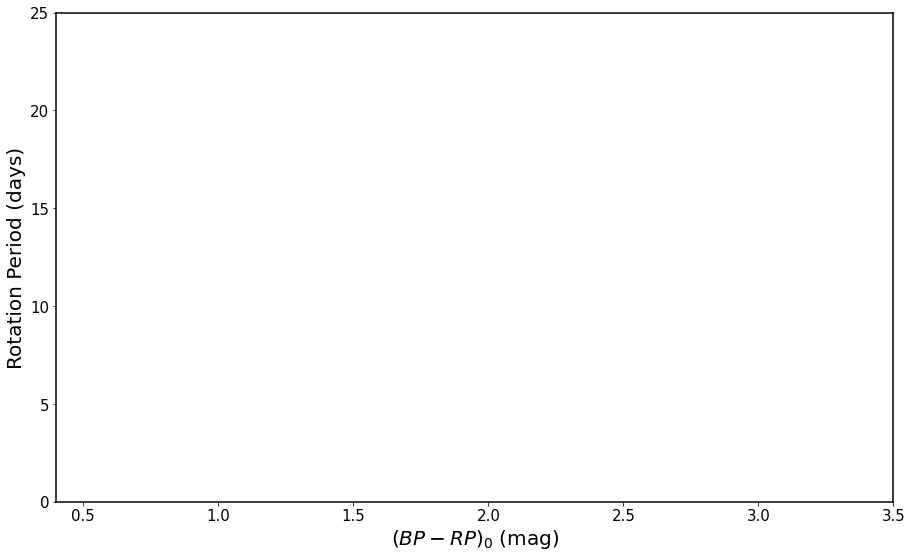

In [16]:
# def prot_show(project_name, user, gbr, clusters=False, pcut=0.0, av=0.0):
# #    gbr = target_data['BP_RP'].to_numpy(dtype=float)
#     fig1, ax1 = plt.subplots(figsize=(15,9)) 
#     ax1.tick_params(axis='both', which='major', labelsize=15)
#     aw = 1.5
#     ax1.spines['top'].set_linewidth(aw)
#     ax1.spines['left'].set_linewidth(aw)
#     ax1.spines['right'].set_linewidth(aw)
#     ax1.spines['bottom'].set_linewidth(aw)

#     prot_table_now = tesscheck.get_prot_table(user,project_name)
#     prot_data_val_now = prot_table_now.get_all_values()
#     prot_data_now = pd.DataFrame.from_records(prot_data_val_now[1:],columns=prot_data_val_now[0])
    
#     pnow = prot_data_now['Prot_Final'].to_numpy()
#     qnow = prot_data_now['Quality'].to_numpy()
#     uu = np.where((pnow != '') & (pnow != '-1') & (gbr != 'nan') & (qnow != '-1'))
# #    uu = np.where((pnow != '') & (pnow != '-1') & (gbr != 'nan'))
#     prot_now = np.array(pnow[uu[0]],dtype=float)
#     color = gbr[uu[0]].astype(float) - 0.415*av
#     power_now = prot_data_now['Power_LS'].to_numpy()
    
#     vv = np.where((power_now[uu[0]].astype(float)>pcut) & (prot_now > 0) & (prot_now < 99))
#     ax1.set_xlim(0.4,3.5)
#     ax1.set_xlabel('$(BP - RP)_0$ (mag)',fontsize=20)
#     ax1.set_ylim(0,25)
#     ax1.set_ylabel('Rotation Period (days)',fontsize=20)

    
#     if clusters == True:
#         file = glob(dir_main+'tess_check/Curtis2020-ClustersTable.txt')
#         clus = Table.read(file[0], format="ascii.cds")
#         indices_Pleiades = np.where((clus["Cluster"] ==  "Pleiades"))
#         indices_Praesepe = np.where((clus["Cluster"] == "Praesepe"))
#         indices_NGC6811 = np.where((clus["Cluster"] == "NGC 6811"))
# #        pleiades = clus.iloc[indicesPl]
# #        praesepe = clus.iloc[indicesPr]
# #        NGC6811 = clus.iloc[indicesNGC]
#         ax1.plot(clus["(BP-RP)0"][indices_Pleiades[0]], clus["Prot"][indices_Pleiades[0]], markerfacecolor = 'blue', markeredgecolor='black', label = '120 Myr Pleiades',markersize=10,alpha=0.7,linestyle='',marker='.')
#         ax1.plot(clus["(BP-RP)0"][indices_Praesepe[0]], clus["Prot"][indices_Praesepe[0]], markerfacecolor = 'cyan', markeredgecolor='black', label = '670 Myr Praesepe',markersize=10,alpha=0.7,linestyle='',marker='.')
#         ax1.plot(clus["(BP-RP)0"][indices_NGC6811[0]], clus["Prot"][indices_NGC6811[0]], markerfacecolor = 'orange', markeredgecolor='black', label = '1 Gyr NGC 6811',markersize=10,alpha=0.7,linestyle='',marker='.')

#     ax1.plot(color[vv[0]], prot_now[vv[0]],markerfacecolor='lightgreen',markeredgecolor='black',marker='*',markersize=20,linestyle='',label=project_name)
# #    ax1.scatter(1.758118-0.415*av,13.2,c='red',s=200)
#     plt.legend(loc='upper left')
#     print("Number of rotators: "+str(len(vv[0])))
# #    ax1.plot([1.2375,1.2375],[0,20],c='green')
# #    ax1.plot([0.5,2.5],[11.677,11.677],c='green')
#     plt.show()

# prot_show(project_name, user, gbr, clusters=True, pcut=0.0, av=0.0)